<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial_for_Neural_Network_Verification_with_Marabou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Robustness Verification with Marabou

---

*As an example we try to verify the **robustness** of a classification network trained on the MNIST dataset.
In this tutorial, we use the SMT-based neural network verification tool [Marabou](https://neuralnetworkverification.github.io/) for this purpose.
Marabou is written in C++ and provides a Python API called Maraboupy.*

---

As in the other tutorials, the focus of this tutorial we don´t focus on details of the preprocessing and training. If you are interested in that part you can look into the training code for this tutorial at our [mnist trainer](https://github.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/lib/mnist_trainer.py). Before starting the tutorials we will import required packages and train a model with the mentioned mnist trainer. The model is defined and then used for solving in marabou. Before solving we also need to build and install Marabou. For more details on that you can take a look at the [sourcecode](https://github.com/NeuralNetworkVerification/Marabou) or the [documentation](https://neuralnetworkverification.github.io/Marabou/).

Our model will be trained with [PyTorch](https://pytorch.org/), as we did in the other tutorials. If you followed them, you can use these models with this tutorial as well. The tutorial can also be executed in Google Colab, where PyTorch is already preinstalled.

In addition, you can also use your own model to verify with Marabou. Marabou can use models of TensorFlow directly, if you want to use PyTorch, we need to export our model to the [Open Neural Network Exchange (ONNX)](https://onnx.ai/) format first, which is a open format for machine learning interoperability.

## Prerequisites

First, we need to import some packages and load the mnist trainer. For export to ONNX, we also import the module ```torch.onnx``` provided by PyTorch. Additionally, we use pip to install ONNX.

In [ ]:
%%capture 
import torch
from torch import nn
import numpy as np
import torch.onnx
import sys

import matplotlib.pyplot as plt

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/mnist_trainer.py'}

import mnist_trainer

In [ ]:
%%capture 
%pip install onnx onnxruntime

## Install Marabou

For installation we followed the instructions of the marabou [documentation](https://neuralnetworkverification.github.io/Marabou/Setup/0_Installation.html). First, we clone the repository and fix a certain commit. You can also use a newer version of Marabou, but the Python API may have changed.

In [ ]:
!git clone https://github.com/NeuralNetworkVerification/Marabou.git
!cd Marabou && git checkout "492c1b8c703c8a383f421468a104c34710e6d26d"

Cloning into 'Marabou'...
remote: Enumerating objects: 25758, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 25758 (delta 32), reused 17 (delta 6), pack-reused 25686
Receiving objects: 100% (25758/25758), 208.88 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (18555/18555), done.
Note: checking out '492c1b8c703c8a383f421468a104c34710e6d26d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 492c1b8c Remove ConstraintBoundTightener (#560)


Marabou and Maraboupy must first be built from source using CMake. The following instructions for Linux or MacOS build and install marabou. They also work in Google Colab, where you can use ```%%shell``` to run multiple shell commands in the current cell. 
The build needs some time depending on available ressources, in Colab it takes about 15 to 20 minutes. 
Don`t matter if the build ends at 98%. In our cases all functions worked well. 

In [ ]:
%%shell
cd Marabou
mkdir build
cd build
cmake .. -DBUILD_PYTHON=ON
cmake --build .
cd /content

To finish the installation and use marabou in python we need to add the path of Maraboupy to the PYTHONPATH. For that we add the path to ```sys.path```-list in python. Use your prefered method to add it to your PYTHONPATH.

In [ ]:
sys.path.insert(1, '/content/Marabou')

Now everything is prepared to import Maraboupy and to use the API in Python.

In [ ]:
%%capture 
from maraboupy import Marabou
from maraboupy import MarabouCore

Set the Marabou option to restrict printing.

In [ ]:
options = Marabou.createOptions(verbosity = 0)

## Train and export Neural Network

In this section, we define and train our neural network, which we want to use for the robustness verification. If you want to use your own model, you can export it in the ONNX format and go to the next section.

Marabou is a more powerful tool than Z3 and so we can define a more complex neural network with more neurons than in the [smt-based solver tutorial](https://github.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial%20for%20SMT%20based%20Verification.ipynb).

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

To train the defined model, we load the mnist dataset and save a dataloader each for training and testing. With the train-dataset we train the defined model. As seen in the constructor of the neural network the dimensions of neurons are a lot bigger than last time.

In [ ]:
%%capture
train_dataloader, test_dataloader = mnist_trainer.load_mnist_dataset(batch_size=64)

In [ ]:
model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 152.60it/s]


Test Error: 
 Accuracy: 90.5%, Avg loss: 0.320908 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 156.78it/s]


Test Error: 
 Accuracy: 91.7%, Avg loss: 0.280069 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 154.95it/s]


Test Error: 
 Accuracy: 92.5%, Avg loss: 0.254752 

Done!


Next, we export the model as a ```.onnx``` format. If you trained a model with tensorflow, you can later import a ```.tf``` model. Marabou also can import ```.nnet``` format. 
We choose the ```.onnx``` format, because you can easily export the model from PyTorch with ```torch.onnx.export(..)```. 

In [ ]:
model_filename = "mnist_net.onnx"

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
dummy_input = torch.randn(1, 28, 28)
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  )

## Verify Robustness With Marabou

Now we have completed all preparations: Marabou is installed and we have trained and exported a neural network. Thus, we can move on to the main part: The robustness verification.

### Import Neural Network into Marabou

First, we need to import the exported model into Marabou. As mentioned, you can import also other model-types or from other frameworks than PyTorch. 
You can take a look at the documentation [here](https://neuralnetworkverification.github.io/Marabou/API/0_Marabou.html#maraboupy.Marabou.read_nnet).

For the ONNX format, you can use the ```read_onnx(..)``` function to get a Marabou network and lists of its input and output variables. In Marabou variables are represented as integer values. You can use them in equations and constraints for the verification. 

In [ ]:
network = Marabou.read_onnx(model_filename)

inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0][0]

Now we need to choose an image for which we want to verify robustness or find an adversarial example. We are using the first image of the training dataset.
Using the Marabou function ```evaluateWithoutMarabou(..)``` we predict the class of the image and visualize it together with the correct class (label). As we can see, the network correctly predicts the image as class *5*.

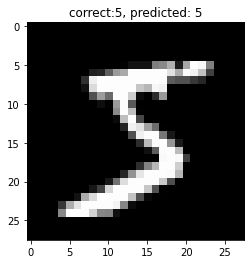

In [ ]:
inputs, classes = next(iter(train_dataloader))
image = inputs[0].numpy()[0]
correct_class = classes[0].item()

network_ouput = network.evaluateWithoutMarabou([image])[0]
predicted_class = np.argmax(network_ouput)

plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(image.reshape(28,28), cmap='gray')

### Encode robustness property with Marabou

As in the last tutorial our goal is to find a pertubation so that the model fails to identify the correct class. This is called the adversarial example. For that we define an epsilon. 
The epsilon is used for the maximum change. In our case this difference can be applied to every pixel of the (grayscale) image.

In [ ]:
epsilon = 0.1

Now we define bounds and constraints for our network, which represent the verification property. 
For a more fundamental understanding of the API, take a close look at the [documentation](https://neuralnetworkverification.github.io/Marabou/API/4_MarabouNetworkONNX.html).

To define the bounds for every pixel, we set the value of the input variables for marabou to the current value of the before shown picture +/- epsilon as lower and upper bounds.

In [ ]:
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    network.setLowerBound(inputVars[h][w], image[h][w] - epsilon)
    network.setUpperBound(inputVars[h][w], image[h][w] + epsilon)

In the next step we define the constraints for the output. As a short remainder: We want to find an advesarial example. This means, that we add a little bit of difference (epsilon) to a correct example. In the end the network should output a different prediction.

With marabou we solve the network with our defined constraints.
Out network outputs 10 values, one for every number of mnist (0...9). 
The maximum output value of the network indicates the predicted number. 
For our constraint this means that another index ```i``` as the correct class has to be greater than the value at the index ```i```.

In the code you see one way to add this constraint. We iterate over each possible class that is different than the correct output and add a max constraint. The max constraint means that the second parameter of the function (here one specific output variable in each loop iteration) has to be the maximum element of the set specifed in the first parameter (all output variables). Then we solve the formula. So, in each iteration Marabou has to find an adversarial example for the specified class. If marabou returns "sat" and finds a solution (an example) we break the loop. 

In [ ]:
for i in range(outputVars.shape[0]):
  if i != correct_class:
    # add max constraint
    network.addMaxConstraint(set(outputVars), outputVars[i])
    # solve
    exit_code, vals, stats = network.solve(verbose = False, options = options)
    # if solution found, break
    print(exit_code)
    if len(vals) > 0:
      break

sat


As Marabou returns "sat", it has found an adversarial example, which we would like to visualize in the next step.

### Visualise the adversarial example

To visualize the adversarial example we extract the input data of the input variables and save that in an numpy array.

In [ ]:
def get_image_from_marabou(inputVariables):
  adversarial_image = [[] for _ in range(inputVariables.shape[1])]
  for h in range(inputVariables.shape[0]):
    for w in range(inputVariables.shape[1]):
      adversarial_image[h].insert(w, vals[inputVariables[h][w]])
  adversarial_image = np.array(adversarial_image)

  return adversarial_image

Now we can visualize the slightly changed adversarial example image calculated by Marabou. If we predict the model without Marabou, we can see that the model does not predict the correct number.

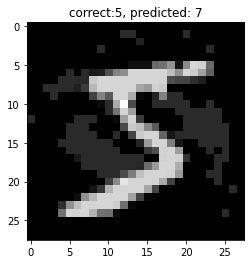

In [ ]:
adversarial_image = get_image_from_marabou(inputVars)
network_ouput = network.evaluateWithoutMarabou([adversarial_image])[0]
predicted_class = np.argmax(network_ouput)

plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(adversarial_image, cmap='gray')

### Use Marabou's robustness function to find an adversarial example

The implementation of Marabou provides also a function to verify the robustness directly (not yet mentioned in the documentation). 
Marabou evaluates the robustness with a given epsilon. 
In the source code the same technique for the constraints is used as well. 
Maybe you can come up with another solution. Feel free to experiment with it!

We use the ```evaluateLocalRobustness(..)``` function to do the same as above and we get another adversarial example.

In [ ]:
network = Marabou.read_onnx(model_filename)
vals, stats, maxClass = network.evaluateLocalRobustness(image, epsilon, correct_class, options=options)

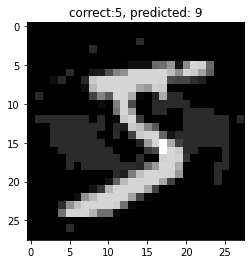

In [ ]:
adversarial_image = get_image_from_marabou(network.inputVars[0][0])
network_ouput = network.evaluateWithoutMarabou([adversarial_image])[0]
predicted_class = np.argmax(network_ouput)

plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(adversarial_image, cmap='gray')

### Verify robustness with a smaller epsilon value

Now we choose a smaller epsilon and try to verify the robustness instead of finding an adversarial example. As we can see, Marabou results in "unsat", which means that the robustness is verified.

In [ ]:
epsilon = 0.05

network = Marabou.read_onnx(model_filename)
network.evaluateLocalRobustness(image, epsilon, correct_class, options=options)

unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat


[{}, <maraboupy.MarabouCore.Statistics at 0x7f82782c57f0>, None]

This concludes our tutorial. Now it's your turn to use different networks for verification or change parameters as you like.